# Draw Confusion Matrix
draw confusion martrix from saved .pt file.  
Notice: you should change the gait_cycle, sampling, and pref_path keyword first, then run all cells.

In [3]:
pegasus = {
    "2dcnn": "/home/SKIING/chenkaixu/code/Filter_PhaseMix_PyTorch/logs/classifier/2dcnn_False_True/2025-07-12/21-04-18/best_preds",
    # "3dcnn": "/home/SKIING/chenkaixu/code/Filter_PhaseMix_PyTorch/logs/classifier/3dcnn_False_True/2025-07-13/10-47-45/best_preds",
	"3dcnn": "/home/SKIING/chenkaixu/code/Filter_PhaseMix_PyTorch/logs/classifier/3dcnn_True_False/2025-07-13/15-43-19/best_preds",
    "cnn_lstm": "/home/SKIING/chenkaixu/code/Filter_PhaseMix_PyTorch/logs/classifier/cnn_lstm_False_True/2025-07-12/21-04-20/best_preds",
    "two_stream": "/home/SKIING/chenkaixu/code/Filter_PhaseMix_PyTorch/logs/classifier/two_stream_False_True/2025-07-13/10-52-11/best_preds",
}

****************************************************************************************************
pegasus, 2dcnn
fold: 5
****************************************************************************************************
2dcnn
accuracy: 0.3559
precision: 0.2495
recall: 0.3559
f1_score: 0.2677
auroc: 0.5300
confusion_matrix:
[[1.9707405e+01 9.5932465e-04 8.0291634e+01]
 [2.3216013e+01 0.0000000e+00 7.6783981e+01]
 [1.2925061e+01 0.0000000e+00 8.7074944e+01]]
####################################################################################################


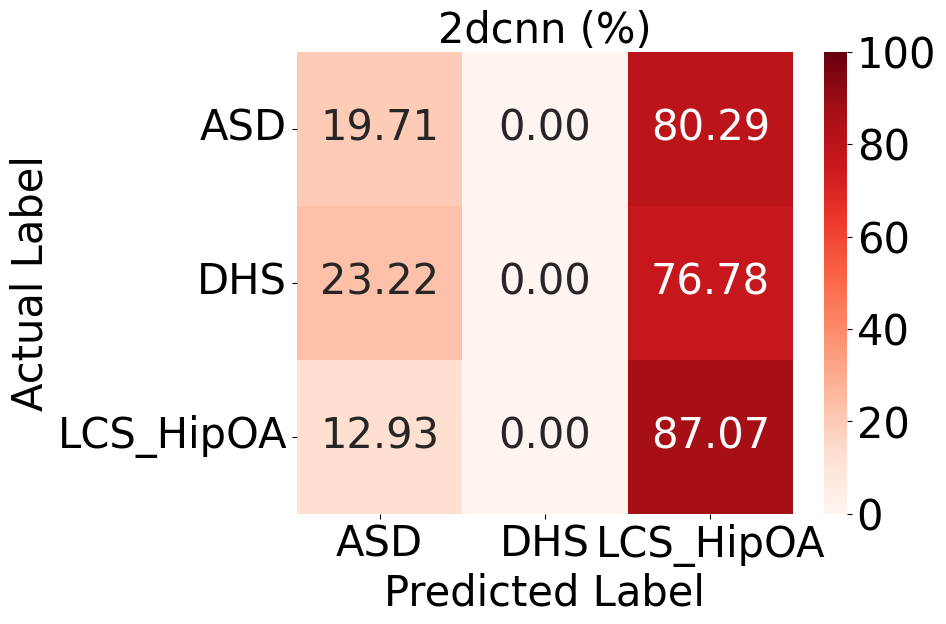

****************************************************************************************************
pegasus, 3dcnn
fold: 3
****************************************************************************************************
3dcnn
accuracy: 0.7021
precision: 0.7149
recall: 0.7021
f1_score: 0.6843
auroc: 0.8388
confusion_matrix:
[[75.71026    13.33504    10.954697  ]
 [45.620052   36.992085   17.387863  ]
 [ 1.7040359   0.35874438 97.93722   ]]
####################################################################################################


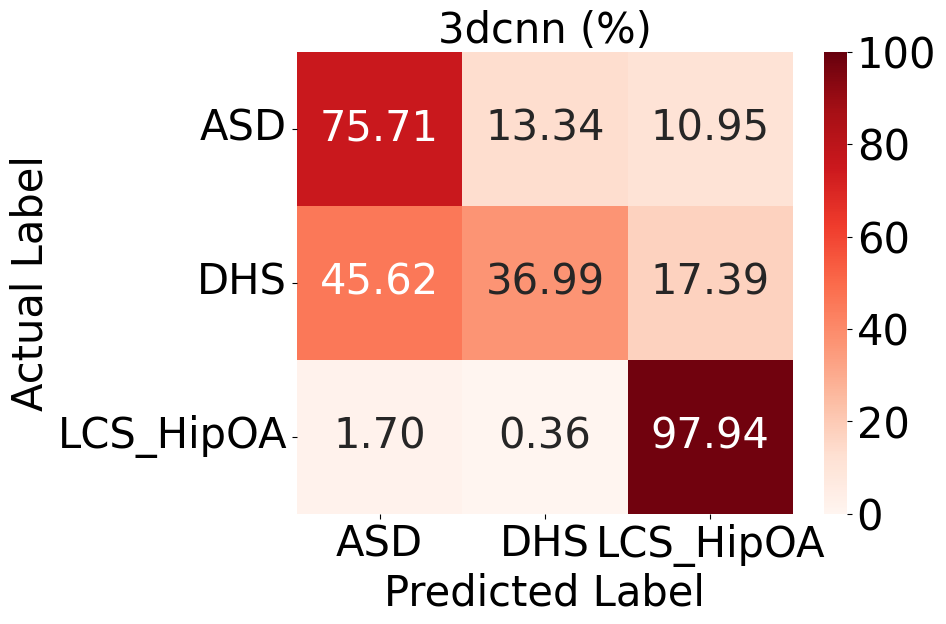

****************************************************************************************************
pegasus, cnn_lstm
fold: 5
****************************************************************************************************
cnn_lstm
accuracy: 0.4161
precision: 0.4079
recall: 0.4161
f1_score: 0.3994
auroc: 0.5768
confusion_matrix:
[[19.343822 29.894474 50.761707]
 [23.187792 37.575592 39.236614]
 [12.963557 19.114109 67.92233 ]]
####################################################################################################


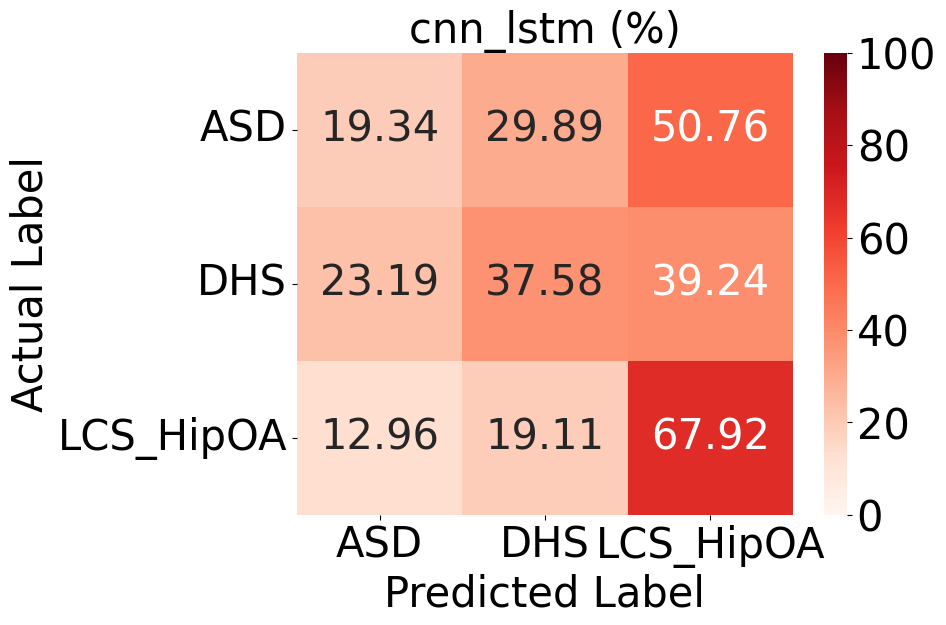

****************************************************************************************************
pegasus, two_stream
fold: 2
****************************************************************************************************
two_stream
accuracy: 0.3333
precision: 0.1045
recall: 0.3333
f1_score: 0.1591
auroc: 0.5791
confusion_matrix:
[[100.   0.   0.]
 [100.   0.   0.]
 [100.   0.   0.]]
####################################################################################################


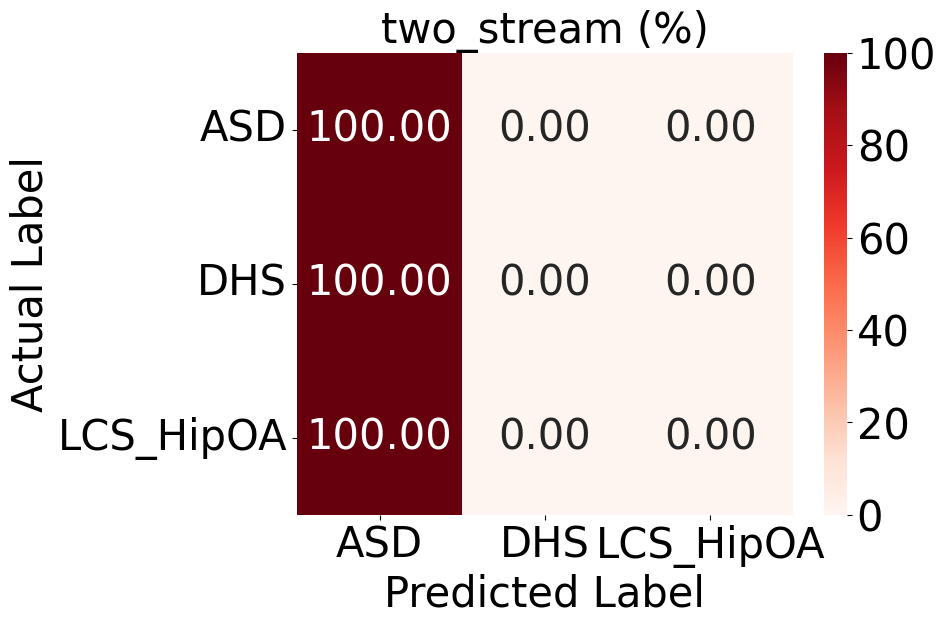

Summary of Metrics:
Model	Fold	accuracy	precision	recall	f1_score	auroc
2dcnn	5	0.35594114661216736	0.249528169631958	0.35594114661216736	0.26765403151512146	0.5299911499023438
3dcnn	3	0.7021318674087524	0.7149412035942078	0.7021318674087524	0.6842939853668213	0.8388369679450989
cnn_lstm	5	0.4161391854286194	0.40786612033843994	0.4161391854286194	0.39941099286079407	0.5768346190452576
two_stream	2	0.3333333432674408	0.10451409220695496	0.3333333432674408	0.1591332107782364	0.5791191458702087



In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
from pathlib import Path
import pandas as pd

from torchmetrics.classification import (
MulticlassAccuracy,
MulticlassPrecision,
MulticlassRecall,
MulticlassF1Score,
MulticlassConfusionMatrix,
MulticlassAUROC,
)

# analysis with title/res path pair

def analysis_with_title_res_path_pair(pair: dict, flag: str = "with_attn_loss"):

	summary_records = []
	
	for title, res_path in pair.items():
		
		fold = 0
		print('*' * 100)
		print(f"{flag}, {title}")
		all_label = []
		all_pred = []
		
		fold = int(len(list(Path(res_path).iterdir())) / 2 )

		print(f"fold: {fold}")

		for i in range(fold):
			label = torch.load(f"{res_path}/{i}_label.pt", map_location="cpu").to(torch.int)
			pred = torch.load(f"{res_path}/{i}_pred.pt", map_location="cpu")
			all_label.append(label)
			all_pred.append(pred)

		all_label = torch.cat(all_label, dim=0)
		all_pred = torch.cat(all_pred, dim=0)
		
		print('*' * 100)
		print(title)
		confusion_matrix_data, metric_dict = metrics(all_pred, all_label, num_class=3)
		print('#' * 100)

		# save summary records
		summary_row = {"Model": title, "Fold": fold}
		summary_row.update(metric_dict)
		summary_records.append(summary_row)

		plt.rcParams.update({'font.size': 30, 'font.family': 'sans-serif'})
		axis_labels = ['ASD', 'DHS', 'LCS_HipOA']

		# draw confusion matrix
		plt.figure(figsize=(8, 6))
		sns.heatmap(confusion_matrix_data, annot=True, fmt='.2f', cmap='Reds', xticklabels=axis_labels, yticklabels=axis_labels, vmin=0, vmax=100)
		# plt.title(f'{title} (%)', fontsize=30)
		plt.title(f"{title} (%)", fontsize=30)
		plt.ylabel('Actual Label', fontsize=30)
		plt.xlabel('Predicted Label', fontsize=30)
		plt.show()
    	
	df_summary = pd.DataFrame(summary_records)
	print("Summary of Metrics:")
	print(df_summary.to_csv(sep="\t", index=False))

def metrics(all_pred: torch.Tensor, all_label: torch.Tensor, num_class: int = 3):
    # define metrics
    _accuracy = MulticlassAccuracy(num_class)
    _precision = MulticlassPrecision(num_class)
    _recall = MulticlassRecall(num_class)
    _f1_score = MulticlassF1Score(num_class)
    _auroc = MulticlassAUROC(num_class)
    _confusion_matrix = MulticlassConfusionMatrix(num_class, normalize="true")

    accuracy = _accuracy(all_pred, all_label).item()
    precision = _precision(all_pred, all_label).item()
    recall = _recall(all_pred, all_label).item()
    f1 = _f1_score(all_pred, all_label).item()
    auroc = _auroc(all_pred, all_label).item()
    cm = _confusion_matrix(all_pred, all_label).cpu().numpy() * 100

    print(f"accuracy: {accuracy:.4f}")
    print(f"precision: {precision:.4f}")
    print(f"recall: {recall:.4f}")
    print(f"f1_score: {f1:.4f}")
    print(f"auroc: {auroc:.4f}")
    print(f"confusion_matrix:\n{cm}")

    metrics_dict = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auroc": auroc,
    }

    return cm, metrics_dict

analysis_with_title_res_path_pair(pegasus, flag="pegasus")